In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
rcParams['figure.figsize'] = 15, 10
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
import datetime as dt
import scipy as sp

In [4]:
os.getcwd()

NameError: name 'os' is not defined

Los datos se encuentran [aqui](https://www.kaggle.com/datasets/ruslanzalevskikh/oil-well). Hacen referencia a distintas mediciones de un mismo pozo petrolero en Rusia. El pozo fue perforado en 2013 y cuenta con una profundidad de 2400 metros.

Estas son las variables y hacen referencia a lo siguiente:
1. **OilVol**: $\text{m}^3 / \text{día}$ el vólumen de petróleo producido
2. **VolLiq**: $\text{m}^3 / \text{día}$ la cantidad total de líquido (mezcla de petróleo, gas y agua) que el pozo produce diariamente en metros cúbicos.
3. **GasVol**: $\text{m}^3 / \text{día}$ la cantidad de gas producido por el pozo por día en metros cúbicos.
4. **WaterVol**: $\text{m}^3 / \text{día}$ Cantidad de agua extraída.
5. **WaterCut**: % El porcentaje de agua presente en el líquido extraído del pozo; es la proporción de agua en  cantidad total del líquido producido.
6. **WorkTime** Número de horas de operación al día.
7. **DnmcLvl**: $\text{m}$ es la altura a la que se encuentra el fluido dentro del pozo mientras la bomba está en funcionamiento y el pozo está produciendo.
8. **Pressure**: $\text{atm}$ es la presión del reservorio medida en atmósferas, la presión disminuye a medida que el pozo es explotado.

# Limpieza de datos

In [5]:
datos = pd.read_excel("Oil well.xlsx" )

In [6]:
datos.head()

,Oil well operation parameters (2013 - 2021 y). Well № 807,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Date,\nOil volume (m3/day),Volume of liquid (m3/day),\nGas volume (m3/day),Water volume (m3/day),Water cut (%),\nWorking hours,\nDynamic level (m),\nReservoir pressure (atm)
2,2013-01-01 00:00:00,49,70,13055,21,29,24,1819,214
3,2013-01-02 00:00:00,49,70,13055,21,29,24,1836,214
4,2013-01-03 00:00:00,49,70,13055,21,29,24,1788,214


In [7]:
datos.columns=['Fecha','OilVol','VolLiq','GasVol','WaterVol','WaterCut','WorkHours','DnmcLvl','Pressure']

In [8]:
datos.drop([0,1],inplace=True)

In [9]:
datos.isnull().sum()

,0
Fecha,0
OilVol,0
VolLiq,0
GasVol,0
WaterVol,0
WaterCut,0
WorkHours,0
DnmcLvl,0
Pressure,0


No hay datos faltantes!


In [10]:
# Establece el índice del d.f. con la columna 'Date'
datos.index = datos['Fecha']

# Elimina la calumna Date del d.f.
datos.drop('Fecha',inplace=True, axis=1); datos

# Convertir todas las columnas de tipo object a numéricas
datos[datos.select_dtypes(include=['object']).columns] = datos.select_dtypes(include=['object']).apply(pd.to_numeric, errors='coerce')


/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


In [11]:
datos.describe()

,OilVol,VolLiq,GasVol,WaterVol,WaterCut,WorkHours,DnmcLvl,Pressure
count,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000
mean,17.624362,59.464103,4730.146308,41.828853,70.694794,22.344675,1930.383464,157.019054
std,9.689026,18.634101,2598.888524,13.056625,9.534203,3.039553,114.543752,32.917150
min,0.000000,12.000000,4.000000,9.000000,29.000000,7.000000,1529.000000,100.000000
25%,11.000000,50.000000,3041.500000,33.000000,69.000000,22.000000,1855.000000,129.000000
50%,15.000000,58.000000,3909.000000,43.000000,73.000000,24.000000,1890.000000,157.000000
75%,22.000000,74.000000,5843.500000,50.000000,76.000000,24.000000,2008.000000,185.500000
max,49.000000,113.000000,13113.000000,99.000000,100.000000,24.000000,2137.000000,214.000000


Dado a que los datos corresponden a las mediciones diarias en cada una de las 8 variables en **UN MISMO POZO**, no es posible ajustar un modelo lineal mixto generalizado pues hay que tener al menos dos individuos o clusters. Por lo tanto debemos ajustar un modelo de series de tiempo a cada variable y caracterizar la estructura de correlación para realizar la predicción a 1 o 2 años.

In [12]:
datos.head()

,OilVol,VolLiq,GasVol,WaterVol,WaterCut,WorkHours,DnmcLvl,Pressure
Fecha,,,,,,,,
2013-01-01,49,70,13055,21,29,24,1819,214
2013-01-02,49,70,13055,21,29,24,1836,214
2013-01-03,49,70,13055,21,29,24,1788,214
2013-01-04,49,70,13055,21,29,24,1789,214
2013-01-05,44,70,11768,26,36,24,1825,214


In [13]:
print(datos.index)

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18'],
              dtype='datetime64[ns]', name='Fecha', length=2939, freq=None)


In [14]:
# Crear un rango de fechas completo para el periodo de los datos
full_range = pd.date_range(start=datos.index.min(), end=datos.index.max(), freq='D')

# Reindexar el DataFrame para incluir todas las fechas (esto agregará NaNs donde no hay datos)
datos = datos.reindex(full_range)

# Asignar la frecuencia diaria
datos.index.freq = 'D'

# Análisis descriptivo de las series

## Vólumen de petróleo

In [18]:
fig = go.Figure([go.Scatter(x=datos.index, y=datos['OilVol'])])
fig.update_layout(title_text="Vólumen de petróleo producido al día.")
fig.update_layout(xaxis_title = 'Fecha', yaxis_title = 'Metros cúbicos por día',template = "plotly_white")


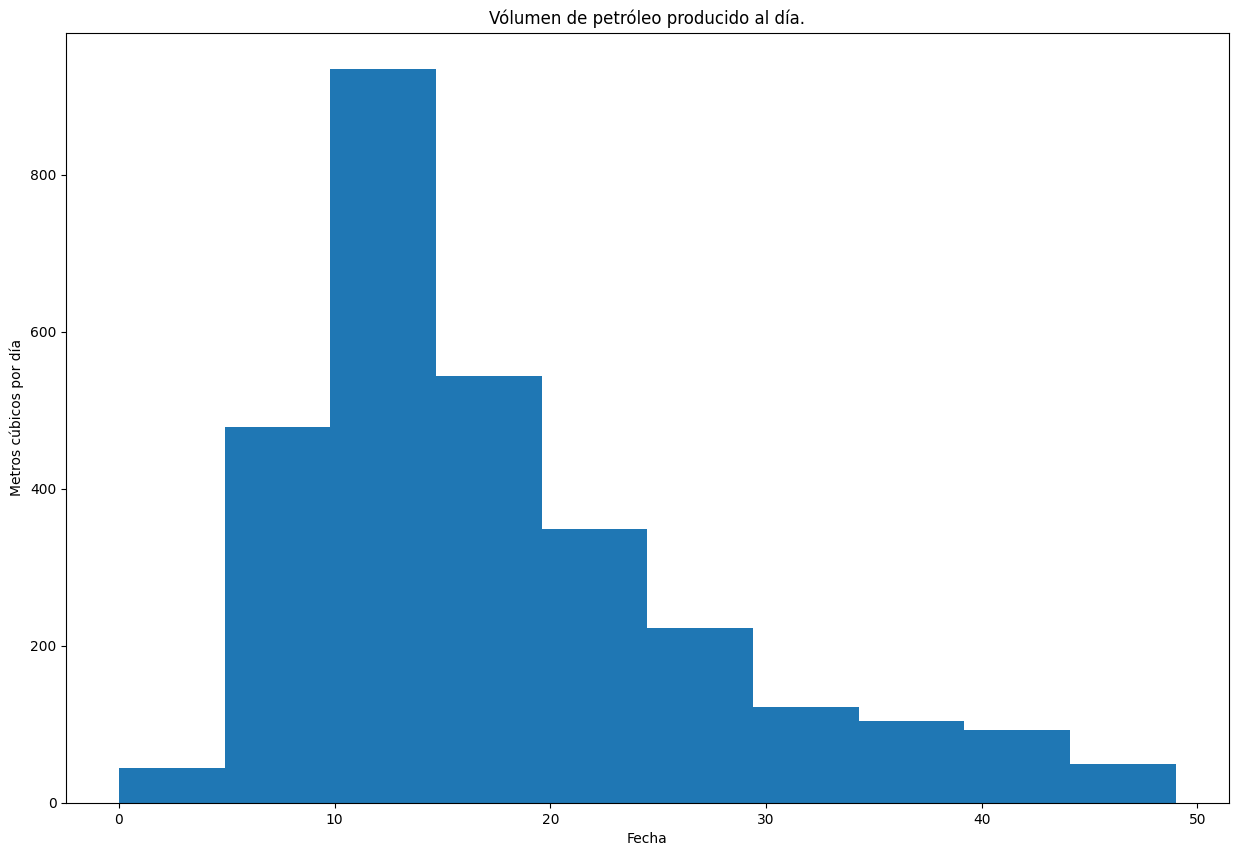

In [21]:
plt.hist(datos['OilVol'])
plt.title('Vólumen de petróleo producido al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

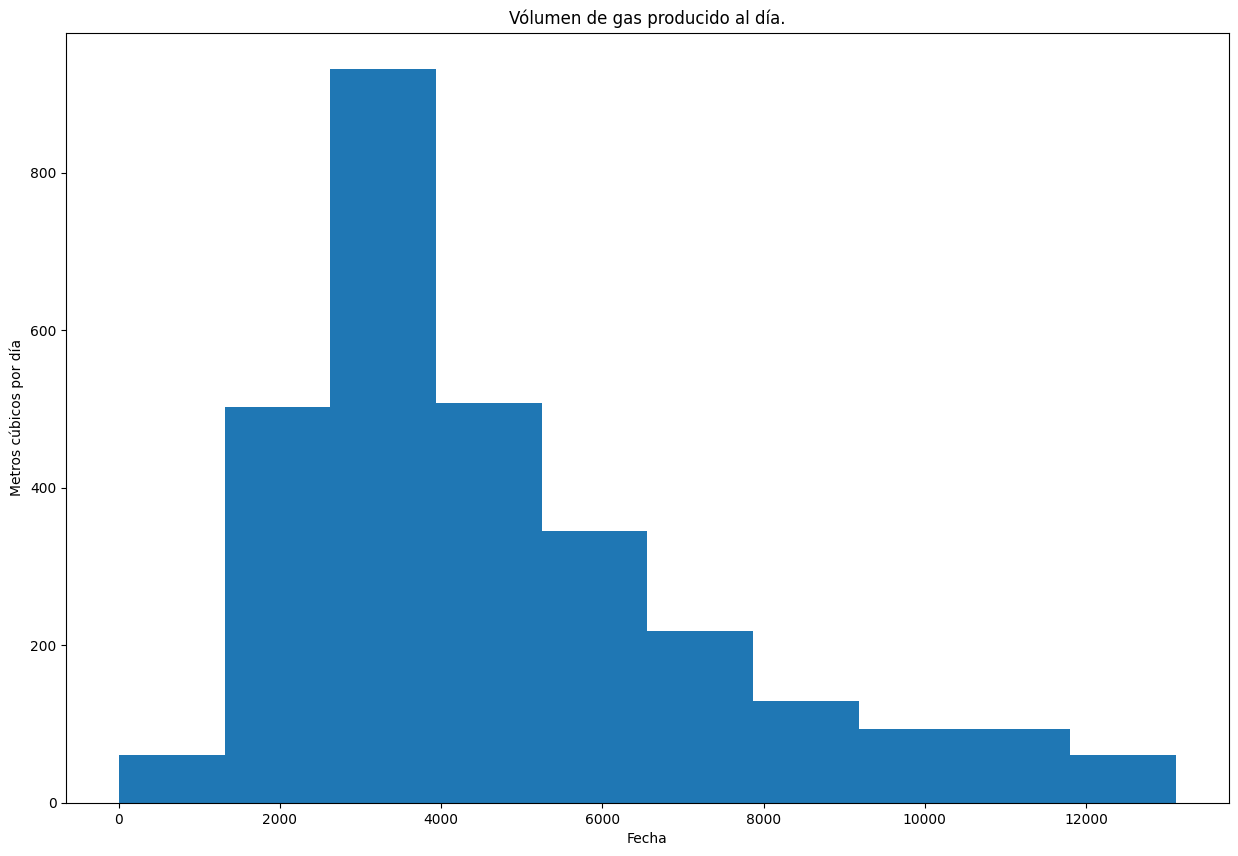

In [25]:
plt.hist(datos['GasVol'])
plt.title('Vólumen de gas producido al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

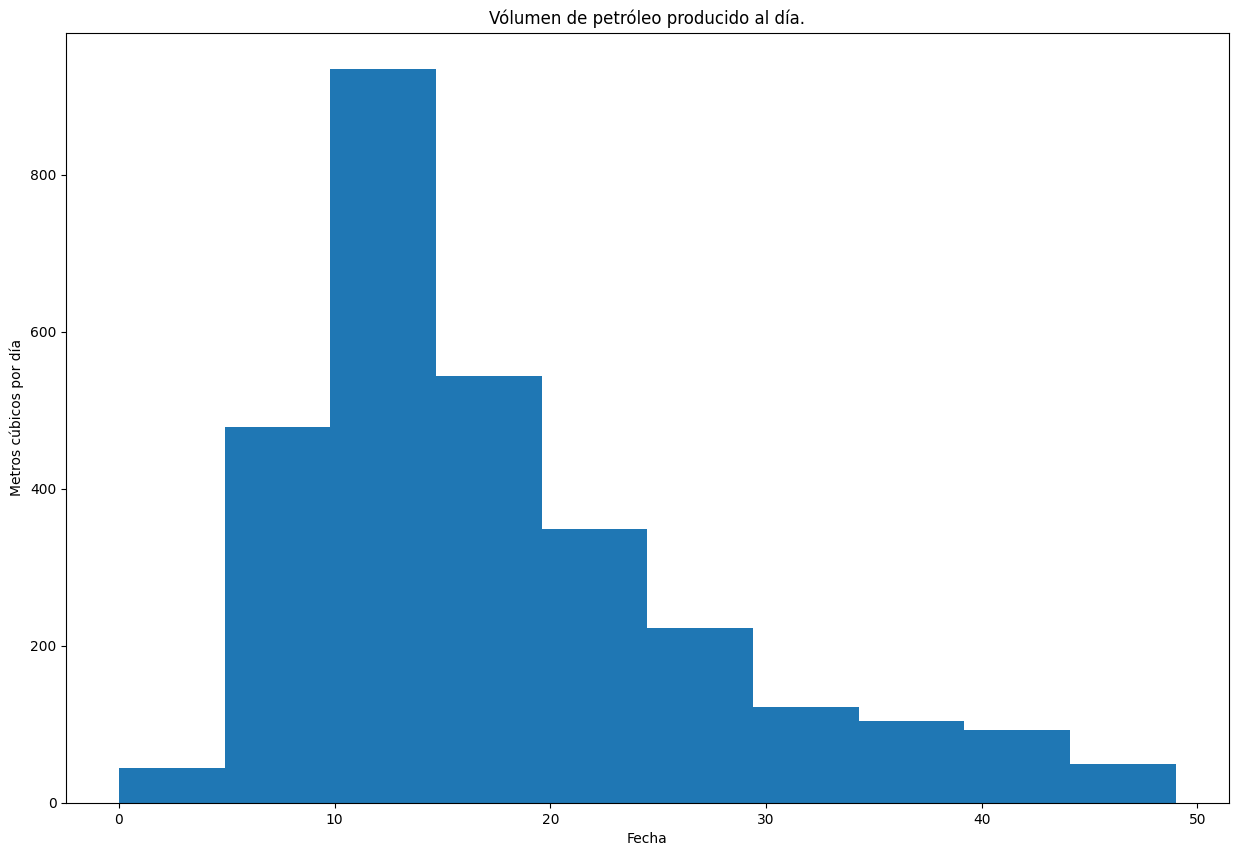

In [24]:
plt.hist(datos['OilVol'])
plt.title('Vólumen de petróleo producido al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()
#

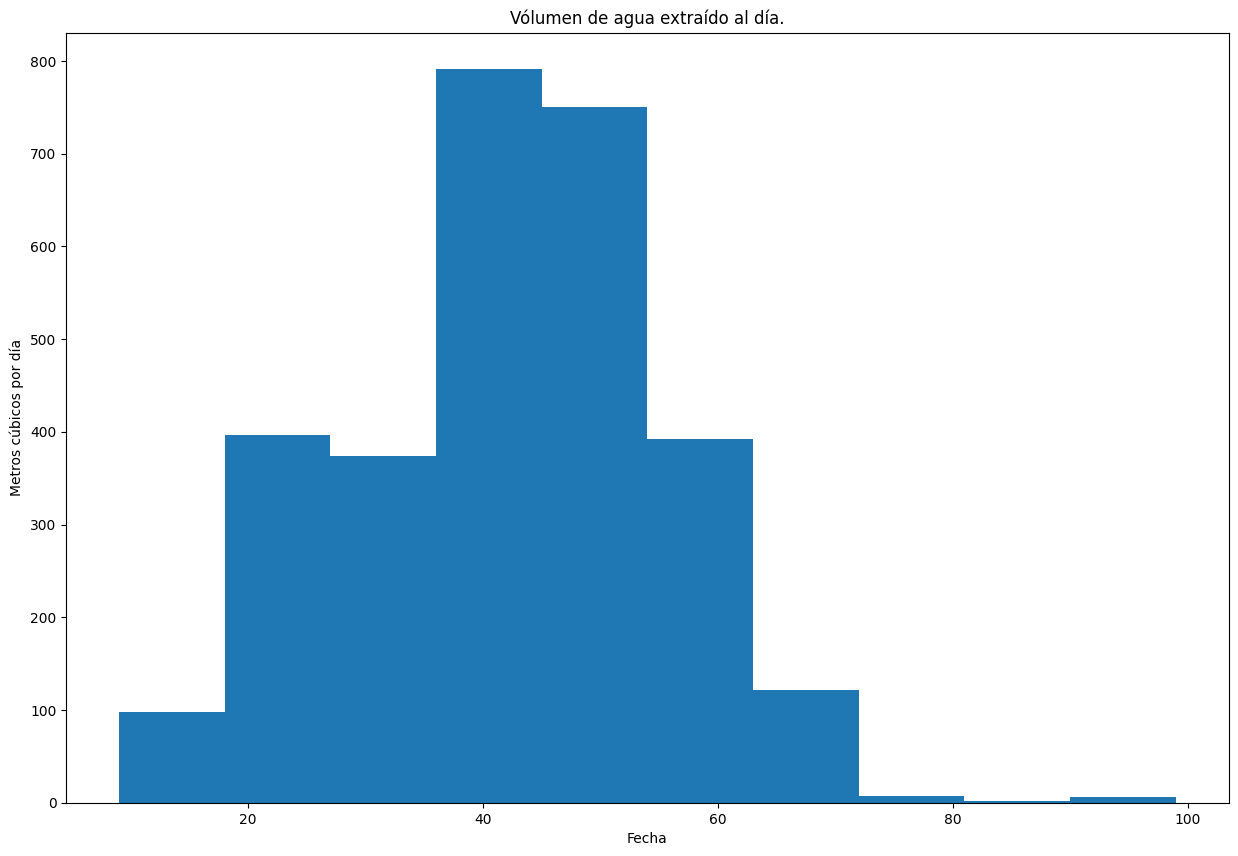

In [26]:
plt.hist(datos['WaterVol'])
plt.title('Vólumen de agua extraído al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

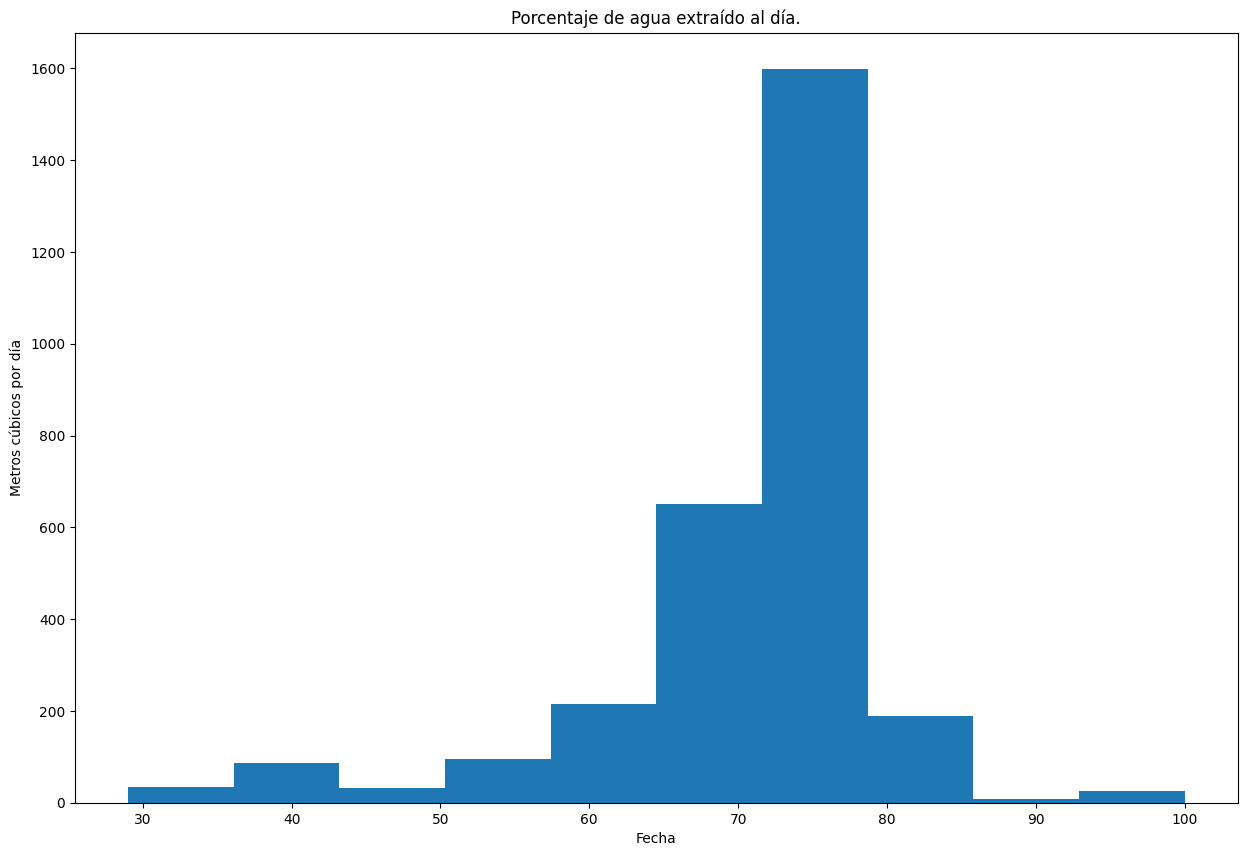

In [27]:
plt.hist(datos['WaterCut'])
plt.title('Porcentaje de agua extraído al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()
#

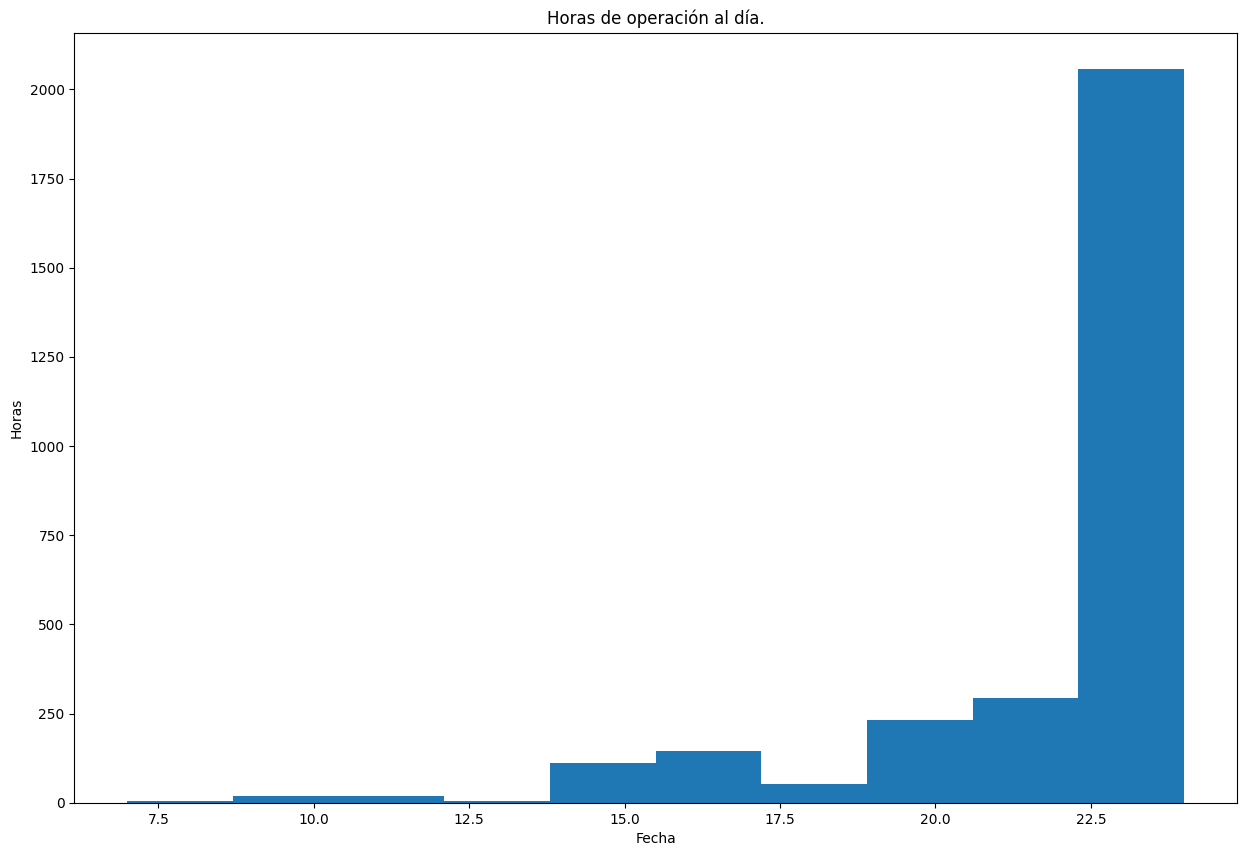

In [28]:
plt.hist(datos['WorkHours'])
plt.title('Horas de operación al día.')
plt.xlabel('Fecha')
plt.ylabel('Horas')
plt.show()
#

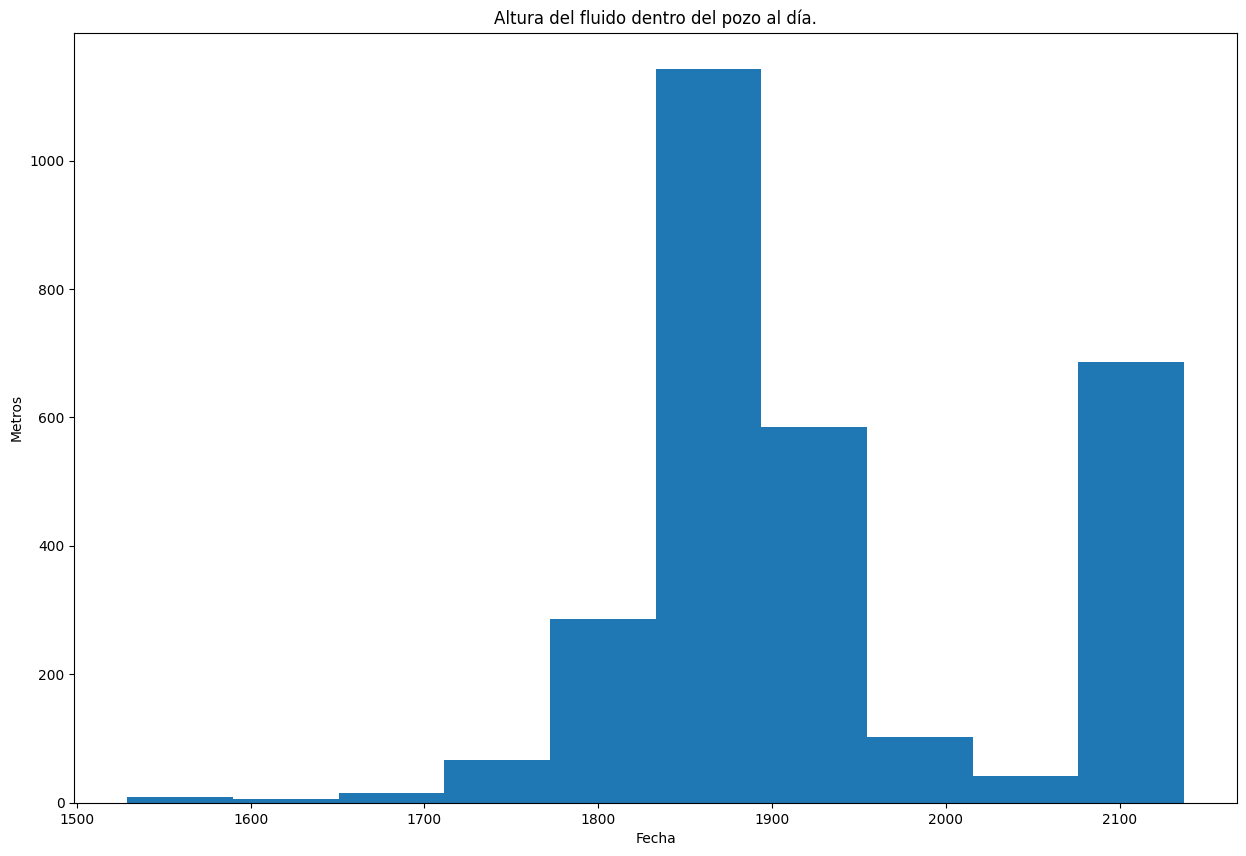

In [29]:
plt.hist(datos['DnmcLvl'])
plt.title('Altura del fluido dentro del pozo al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros')
plt.show()

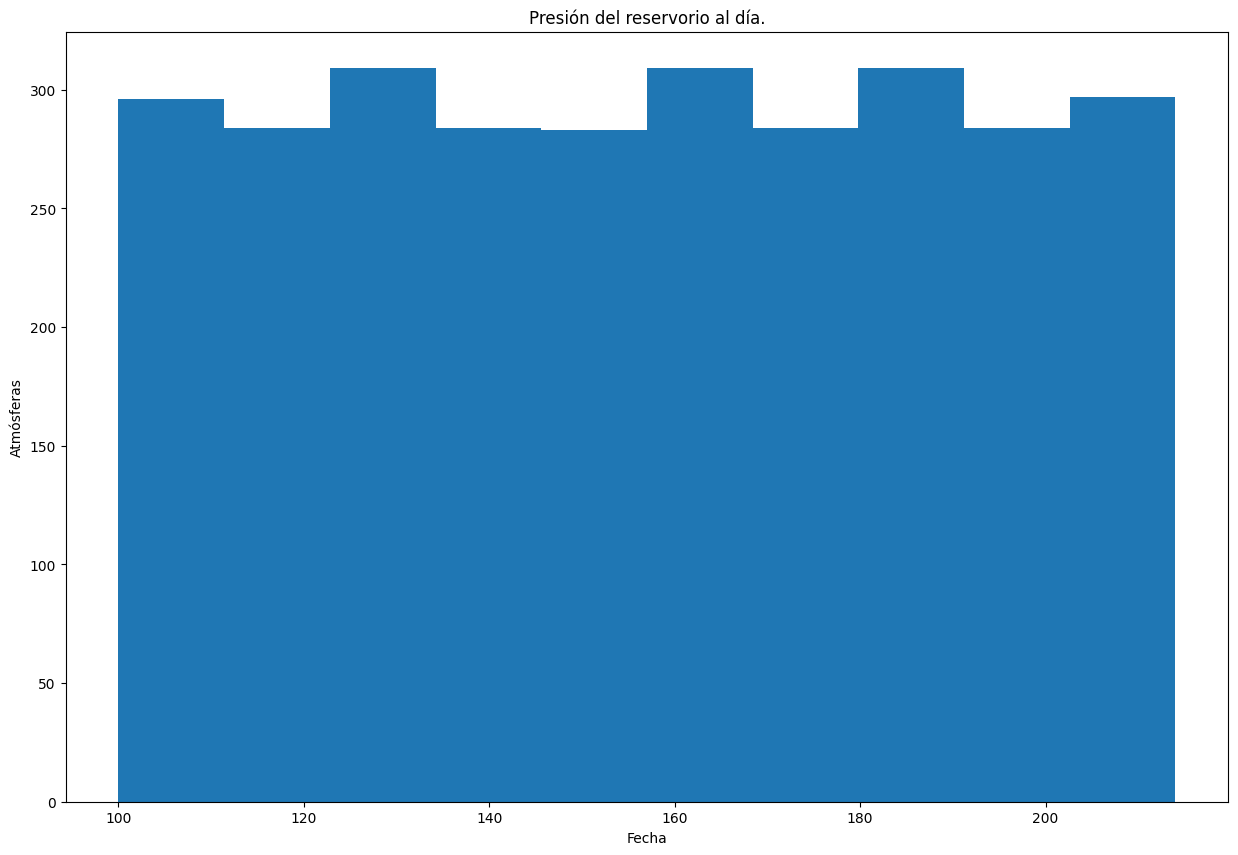

In [30]:
plt.hist(datos['Pressure'])
plt.title('Presión del reservorio al día.')
plt.xlabel('Fecha')
plt.ylabel('Atmósferas')
plt.show()

Se puede ver que la serie presenta una componente de tendencia, en particular es decreciente y tiene sentido en el contexto en que estamos.

Vamos a usar la componente de tendencia que se estima por medio de filtor de promedios móviles.

In [20]:
####Descomposición usando filtros
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

###También se puede hacer vía STL###
result = seasonal_decompose(datos['OilVol'].dropna(), model='additive',extrapolate_trend=6)

descomposicion_chicken=result.plot()
pyplot.show()



ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

Se hará uso del periodograma y la función de autocorrelación para determinar si existe alguna componente estacional.

In [ ]:
f, Pxx_den=sp.signal.periodogram(datos['OilVol'])
plt.plot(f, Pxx_den)
#plt.axvline(x=1/50,color='red')
max_index_value = np.argmax(Pxx_den, axis=0)
print(max_index_value)
frecuencia_max=f[max_index_value]
print(frecuencia_max)
print(1/frecuencia_max)

Esto es una prueba